# Data Analyst Associate Practical Exam Submission

## Background
- PetMind is a retailer of products for pets. They are based in the United States.
- PetMind sells products that are a mix of luxury items and everyday items. Luxury items include
- toys. Everyday items include food.
- The company wants to increase sales by selling more everyday products repeatedly.
- They have been testing this approach for the last year.
- They now want a report on how repeat purchases impact sales.

***
## Task 1

For every column in the data:
- State whether the values match the description given in the table above.
- State the number of missing values in the column.
- Describe what you did to make values match the description if they did not match.


In [2]:
import pandas as pd
import seaborn as sb
from pandasql import sqldf 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

pet_supplies = pd.read_csv('pet_supplies_2212.csv')
pysqldf = lambda q: sqldf(q, globals())

In [3]:
# Clean the data, replacing missing values
q_clean = """
SELECT
    product_id
    ,replace(category, '-', 'Unknown') as category
    ,animal
    ,upper(size) as size
    ,replace(price, 'unlisted', (SELECT ROUND(AVG(price),2)
                                    FROM (SELECT price
                                          FROM pet_supplies
                                          ORDER BY price
                                          LIMIT 2
                                          OFFSET (SELECT (COUNT(*) - 1) / 2
                                                  FROM pet_supplies
                                                  where price != 'unlisted')))) as price
    ,sales
    ,coalesce(rating, 0) as rating
    ,CASE 
        WHEN repeat_purchase = 1 then "1"
        ELSE "0"
        END AS rp
FROM
	pet_supplies 
"""

# Run the query and display the result
data_cleaned = pysqldf(q_clean)
data_cleaned

,product_id,category,animal,size,price,sales,rating,rp
0,1,Food,Bird,LARGE,51.1,1860.62,7.0,1
1,2,Housing,Bird,MEDIUM,35.98,963.60,6.0,0
2,3,Food,Dog,MEDIUM,31.23,898.30,5.0,1
3,4,Medicine,Cat,SMALL,24.95,982.15,6.0,1
4,5,Housing,Cat,SMALL,26.18,832.63,7.0,1
...,...,...,...,...,...,...,...,...
1495,1496,Food,Bird,MEDIUM,40.91,1203.36,5.0,0
1496,1497,Equipment,Dog,SMALL,32.89,1099.97,5.0,0
1497,1498,Food,Fish,SMALL,25.79,724.02,3.0,0
1498,1499,Medicine,Fish,SMALL,19.94,658.66,5.0,1


The original dataset provided contains 1500 rows and 8 columns.

Here's what we can observe going through each column in the dataset:
- **product_id:** there are 1500 unique identifiers, with no missing values, as expected.
- **category:** there are 6 categories, named as expected. The category was missing for 25 rows, in which it was replaced with "Unknown".
- **animal:** there are 4 animals, named as expected, with no missing values.
- **size:** there are 3 sizes, as expected, with no missing values, however, there are different letter cases across the 1500 rows, therefore the values were normalized so there are only 3 distinct values for the size.
- **price:** prices are continuous positive values, round to 2 decimal places, as expected. There are 150 missing values (set as "unlisted"), which have been replaced with the overall median price.
- **sales:** sales are continuous positive values, round to 2 decimal places, as expected. There are no missing values.
- **rating:** the values are discrete, between 1 and 10, as expected. There are 150 missing values, which have been replaced by 0.
- **repeat_purchase**: the values are either 0 or 1, as expected. Some of the values contain "-0", which has been interpreted as 0. There are no missing values.

***
## Task 2

Create a visualization that shows how many products are repeat purchases. Use the visualization to:
- State which category of the variable repeat purchases has the most observations.
- Explain whether the observations are balanced across categories of the variable repeat purchases.

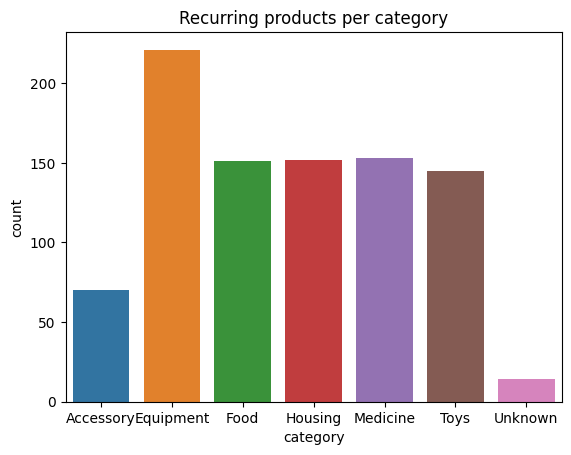

In [4]:
# Select the count of recurring products per category
q_rp = """
SELECT
    category
    ,count(*) as count
FROM
    data_cleaned
WHERE
    rp = 1
GROUP BY
    category
"""

# Select the count of all products per category
q_total = """
SELECT
    category
    ,count(*) as count
FROM
    data_cleaned
GROUP BY
    category
"""

# Run both queries
rp = pysqldf(q_rp)
total = pysqldf(q_total)

# Create and display a bar plot for recurring products per category
graph = sb.barplot(data=rp, x="category", y="count").set(title="Recurring products per category")
plt.show()

For the analysis that follows, products offering the option of repeat purchases will be referred to as **recurring products**. 

There are six categories containing recurring products, plus a few recurring products having an undefined category (Unknown). The category having the most observations for recurring products is Equipment, with over 200 recurring products, so it has a larger offering of recurring products than the other categories. Next comes Food, Housing, Medicine, and Toys, which have roughly the same amount of recurring products (around 150), so there's a balance across these specific categories. Finally, Accessory has roughly half the amount of recurring products when compared to the four categories previously described. 

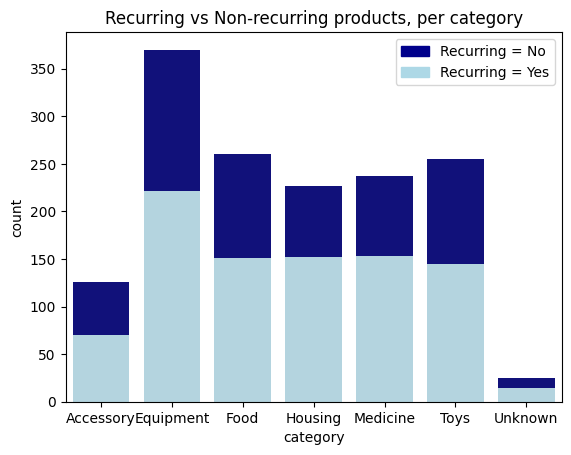

In [5]:
# Create a bar plot for recurring and total products per category
bar1 = sb.barplot(x="category",  y="count", data=total, color='darkblue').set(title="Recurring and Non-recurring products, per category")
bar2 = sb.barplot(x="category", y="count", data=rp, color='lightblue')

# Define the bottom and top bar in the graph to create a stacked bar plot of recurring and non-recurring products
top_bar = mpatches.Patch(color='darkblue', label='Recurring = No')
bottom_bar = mpatches.Patch(color='lightblue', label='Recurring = Yes')
plt.legend(handles=[top_bar, bottom_bar])

plt.show()

Since PetMind is particularly interested in increasing sales by offering more recurring products of everyday use (i.e. Food), we should also look into recurring and non-recurring items in the category, to evaluate how much room there is to increase the number of recurring products.

Through the graph **Recurring and Non-recurring products** we can see that, although the Food category already offers over 150 recurring products, there are still over 100 other Food products that can be potentially offered as recurring. 

***
## Task 3

Describe the distribution of all of the sales. Your answer must include a visualization
that shows the distribution.

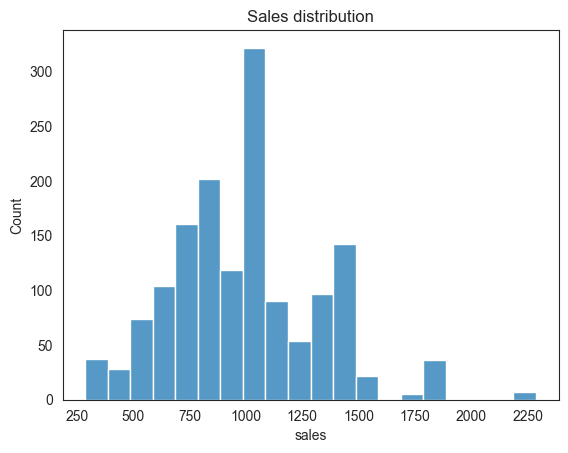

In [6]:
# Select all sales
q_sales = """
SELECT
    sales
FROM
    data_cleaned
"""

# Run the query
sales = pysqldf(q_sales)

# Create a histogram showing the sales distribution
# Interval: 100 sales
sb.set_style("white")
sb.histplot(data=sales, x="sales", binwidth=100).set(title="Sales distribution")
plt.show()

In order to observe how products are performing, we can distribute the sales in intervals of 100 sales, and see that most products have around 1100 sales or less, with a few of them getting up to around 1500 sales. A small portion of products, considered outliers, have higher sales than that, going up to around 2250 sales. 

This graph alone won't tell us whether selling a product recurrently is connected with a higher number of sales, so let's compare these variables on Task 4. 

***
## Task 4

Describe the relationship between repeat purchases and sales. Your answer must include a visualization to demonstrate the relationship.

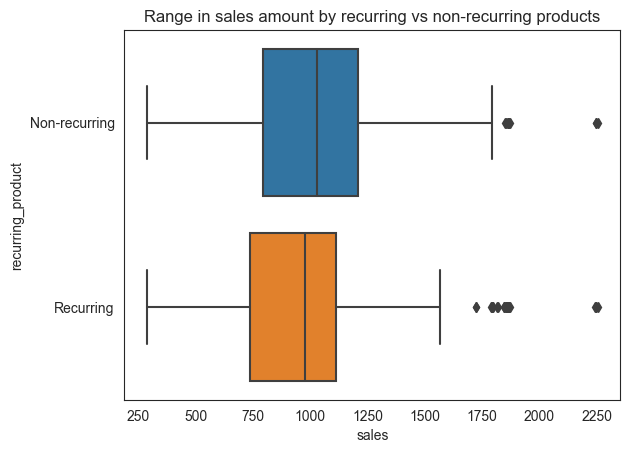

In [7]:
# Select all sales and the corresponding product type (recurring vs non-recurring)
q_rp_sales = """
SELECT
    sales
    ,CASE
        WHEN rp = 1 THEN "Recurring"
        ELSE "Non-recurring"
        END AS recurring_product
FROM
    data_cleaned
ORDER BY
    recurring_product
"""

# Run the query
rp_sales = pysqldf(q_rp_sales)

# Create a box plot showing the relation between sales and recurring/non-recurring products
sb.set_style("white")
sb.boxplot(data=rp_sales, x="sales", y="recurring_product").set(title="Range in sales amount by recurring vs non-recurring products")
plt.show()

Let's now compare the variables and see how a product being recurring or non-recurring impacts its amount of sales. PetMind wants to increase its number of sales by turning more everyday products, such as Food, into recurring products, so we should check whether recurring products sell more than non-recurring products.

Looking at the box plot, the median of both recurring and non-recurring products are close to each other, as well as the size of their interquartile range, suggesting that the sales performance of recurring vs. non-recurring products is similar, although non-recurring products perform slightly better on average.

In both groups, there are some outliers on the right, representing products with a high volume of sales. Having products with a high volume of sales is positive, and there are more outliers in the recurring products group. However, we must be careful when taking those outliers into account, since the group of recurring products contains more products - 906 products are recurring, whereas 594 are non-recurring - therefore while this could be an indication that recurring products sell more, it may also be natural to have more outliers in this group due to its size. 

If we disregard the outliers, the spread is slightly smaller among recurring products, indicating their sales are more predictable. 

Let's also observe both groups in a histogram, using independent density normalization, since the groups differ greatly in size:

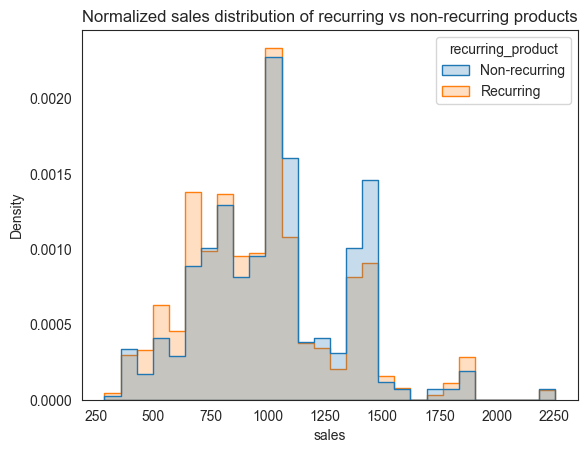

In [8]:
# Create a histogram showing the normalized sales distribution for each product type
sb.histplot(data=rp_sales, x="sales", hue="recurring_product", element="step", stat="density", common_norm=False).set(title="Normalized sales distribution of recurring vs non-recurring products")
plt.show()

What we're viewing in the histogram above is similar to what we see in the boxplot. Recurring and non-recurring products have similar performance in terms of sales. Given the higher predictability of sales for recurring products, and having outliers in that group that perform slightly better, turning some everyday products, such as Food, into recurring products, could help boost their sales.